# Plot wind data vertical modes in mixed layer

About 50 km north of Barkley Canyon

In [17]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import scipy.misc as deriv
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [28]:
# import data

ds = xr.open_dataset(f'../../../Data/wind/wind.nc')
#print(ds)
    
N2_array = np.load('../N2/buoyancy_array.npy')
N2_depths = N2_array[0]                                 # depths range from -4 to -924 metres
N2_values = N2_array[1]
depth = np.linspace(0,980,981)
N2_int = np.interp(depth,-N2_depths,N2_values)

In [3]:
# select data

year = 2013
t_stamp = f'{year}'
start_date = np.datetime64(f'{year}-01-01')
end_date = np.datetime64(f'{year+1}-01-01')

if year == 2013:
    dt_tot = ds.dt2013
    wdir_tot = ds.wdir2013
    wspd_tot = ds.wspd2013
elif year == 2014:
    dt_tot = ds.dt2014
    wdir_tot = ds.wdir2014
    wspd_tot = ds.wspd2014
elif year == 2017:
    dt_tot = ds.dt2017
    wdir_tot = ds.wdir2017
    wspd_tot = ds.wspd2017
elif year == 2018:
    dt_tot = ds.dt2018
    wdir_tot = ds.wdir2018
    wspd_tot = ds.wspd2018

In [4]:
# get data segments in lists

if year == 2013:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg = 1
elif year == 2014:
    dt0 = dt_tot[:621]
    dt1 = dt_tot[621:]
    dt = [dt0,dt1]
    wspd0 = wspd_tot[:621]
    wspd1 = wspd_tot[621:]
    wspd = [wspd0,wspd1]
    wdir0 = wdir_tot[:621]
    wdir1 = wdir_tot[621:]
    wdir = [wdir0,wdir1]
    n_seg = 2
elif year == 2017:
    dt0 = dt_tot[:3974]
    dt1 = dt_tot[4100:5017]
    dt2 = dt_tot[5080:]
    dt = [dt0,dt1,dt2]
    wspd0 = wspd_tot[:3974]
    wspd1 = wspd_tot[4100:5017]
    wspd2 = wspd_tot[5080:]
    wspd = [wspd0,wspd1,wspd2]
    wdir0 = wdir_tot[:3974]
    wdir1 = wdir_tot[4100:5017]
    wdir2 = wdir_tot[5080:]
    wdir = [wdir0,wdir1,wdir2]
    n_seg = 3
elif year == 2018:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg = 1

## Vertical mode decomposition (outlined by Jody, Alford, Zhen, etc.)

In [5]:
# get horizontal mixed layer velocity components

# import data

ds_in = xr.open_dataset(f'../../../Data/wind/ml_currents_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    dsw = [ds_in]
    for i in range(n_seg):
        if i > 0:
            dsw_temp = xr.open_dataset(f'../../../Data/wind/ml_currents_{year}_{i}.nc')
            dsw.append(dsw_temp)
elif n_seg == 1:
    dsw = [ds_in]

In [6]:
# vertical near-inertial energy transfer parameters

Nmix = 2.52e-3        # base of mixed layer N [Hz]
cor = 1.74e-5         # local Coriolis parameter [Hz]
#L = 400               # length scale, from paper (in km???)
roh = 1024            # avg density of mixed layer seawater from N2 calculations (similar for either season)
D = []
for i in range(n_seg):
    Dtemp = dsw[i].H.values             # depth of mixed layer through time
    D.append(Dtemp)

In [7]:
# band pass around f

ubp,vbp = [],[]   # empty lists for filtered data
fs = 2.777e-4                               # samples per SECOND for entire time series
Wn = [1.55e-5,2.00e-5]                      # cut-off frequencies
sos = sig.butter(8, Wn,'bandpass', fs=fs, output='sos')   # digital butterworth filter
w,h = sig.sosfreqz(sos) 
#plt.semilogx(w*fs/(2*np.pi),abs(h))

for i in range(n_seg):
    ufilt = np.copy(dsw[i].Zu.values)       # copy unfiltered array
    ubp_temp = sig.sosfiltfilt(sos, ufilt)    # apply band pass filter
    vfilt = np.copy(dsw[i].Zv.values)       # repeat for v
    vbp_temp = sig.sosfiltfilt(sos, vfilt)
    ubp.append(ubp_temp)
    vbp.append(vbp_temp)

In [8]:
# get depth-integrated vertical velocities from NI mixed layer horizontal velocities

# def divergence(f):
#     """
#     Computes the divergence of a vector field at point f, corresponding to du/dt + dv/dt
#     :param f: List of TWO ndarrays, where every item of the list is one dimension of the vector field (u, v)
#     :return: Single ndarray of the same shape as each of the items in f, with scalar output
#     """
#     a = np.gradient(f[0],3600)     # 3600, spacing in seconds between values
#     b = np.gradient(f[1],3600)
#     ab = np.sum([a,b],axis=0)
#     return ab

# wxDt = []
# for i in range(n_seg):
#     div = divergence([dsw[i].Zu.values,dsw[i].Zv.values])
#     wxDt_temp_list = []
#     for j in range(div.size):
#         wxDt_temp = D[i][j]*div[j]             # depth-integrated vertical velocities in mixed layer
#         wxDt_temp_list.append(wxDt_temp)
#     wxDt.append(wxDt_temp_list)

In [9]:
# jody function for vertical modes

from matplotlib import pylab

def vertModes(N2,dz,nmodes=0): 
    """" psi,phi,ce,z=vertModes(N2,dz,nmodes=0)
    
    Compute the vertical eigen modes of the internal wave solution on a flat bottom
    
    Parameters:
    ----------- 
    N2 : (M) is buoyancy frequency squared (rad^2/s^2) as an 1-D
         array.  If there are M values of N2, the first one is assumed
         to be at dz/2 deep, and the last one is H-dz/2 deep.  The
         water column is assumed to be H=M*dz deep.  No gaps are
         allowed, and N2>0 everywhere.       
    dz : is a single value, and the distance (in meters) between the N2 estimates
    nmodes : number of modes to return.  nmodes = 0 means return M-3 modes.
            
         
    Returns:
    --------
    psi : (M,M-2) is the vertical structure function at
         z=dz/2,3dz/2,2dz...,H-dz/2.  Note there is one extra value
         compared to N2 (ie there are M+1 values in depth). psi is
         normalized so that sum(psi^2 dz) = 1.  For internal waves,
         psi is approriate for velocity and pressure vertical
         structure.          
    phi : (M,M-2) is the vertical integral of psi (phi = int psi dz)
         and represents the vertical velocity structure.  It is
         interpolated onto the same grid as psi.
    ce : (M-2) is the non-rotating phase speed of the waves in m/s.
    z :  (M) is the vertical position of the psi and phi vector elements.
             
    Notes: 
    ------
    This solves 1/N**2 psi_{zz} + (1/ce**2)psi = 0 subject to a
    boundary condition of zero vertical velocity at the surface and
    seafloor.
  
    psi(0)=0 (rigid lid approx)
    psi(H)=0
    
    It is solved as an eigenvalue problem.  
    Also note that if 
             
    J. Klymak (Based on code by Sam Kelly and Gabe Vecchi)           
    """

    import numpy as np
    
    # First we are solving for w on dz,2dz,3dz...H-dz
    M = np.shape(N2)[0]-1
        
    if M>200:
        sparse = True
        if nmodes==0:
            nmodes = 100 # don't try too many eigenvectors in sparse mode...
    else:
        sparse = False
        if nmodes==0:
            nmodes = M-2
    
    N2mid = N2[:-1]+np.diff(N2)/2.
    # matrix for second difference operator
    D = np.diag(-2.*np.ones(M),0)
    D += np.diag(1.*np.ones(M-1),-1)
    D += np.diag(1.*np.ones(M-1),1)

    D=-D/dz/dz
    D = np.diag(1./N2mid).dot(D)
    ce,W = np.linalg.eig(D)
    # psi is such that sum(psi^2)=1 but we want sum(psi^2 dz)=1.
    W = W/np.sqrt(dz)
    ce = 1./np.sqrt(ce)
    ind=np.argsort(-ce)
    
    ce=ce[ind[:-2]]
    W=W[:,ind[:-2]]
    # zphi
    zphi = np.linspace(dz/2.,((M+1)*dz)-(dz/2.),M+1)

    # now get phi (w structure) on dz/2,3dz/2...
    phi = np.zeros((M+1,M+1-3))
    phi[0,:]=0.5*(W[0,:])
    phi[1:-1,:]=0.5*(W[:-1,:]+W[1:,:])
    phi[-1,:]=0.5*(W[-1,:])
    
    # Now get psi (u/p structure) on dz/2,3dz/2...
    psi = np.zeros((M+1,M+1-3))
    psi[0,:] = W[0,:]
    psi[1:-1,] = np.diff(W,axis=0)
    psi[-1,:] = -W[-1,:]
    
    A = np.sqrt(np.sum(psi*psi,axis=0)*dz)
    psi = psi/A
    phi = phi/A
    # flip sign so always same sign in psi at top:
    phi[:,psi[0,:]<0] *= -1
    psi[:,psi[0,:]<0] *= -1

    return psi,phi,ce,zphi

c theory: 0.9607 c[0]: 0.9885
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  -2.03e-11
int psi 0 psi 2:  -1.71e-11
int psi 0 psi 3:  -4.01e-12
int Nsq phi 0 phi 0:  9.72e-01
int Nsq phi 0 phi 1:  -2.27e-05
int Nsq phi 0 phi 2:  -3.67e-06
int Nsq phi 0 phi 3:  -9.09e-07


<IPython.core.display.Javascript object>


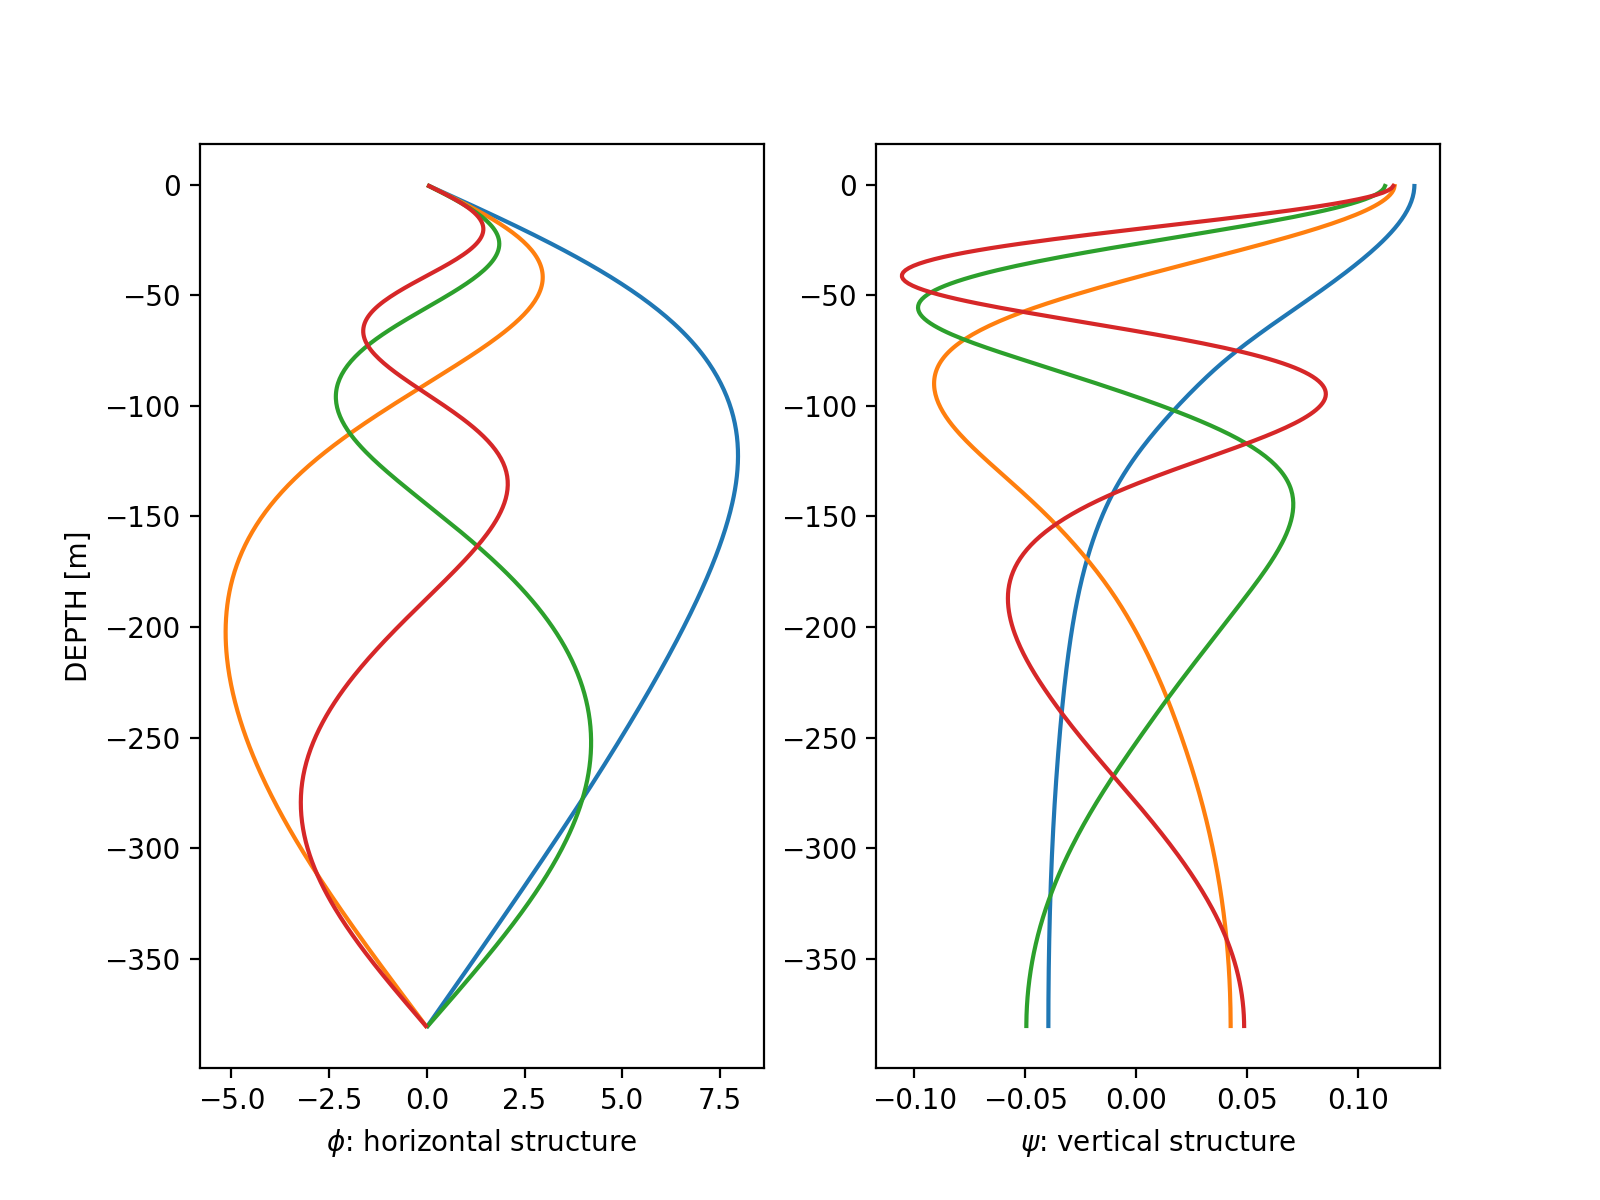

In [62]:
# jody code for vertical modes

site = 'Slope'

if site == 'Slope':
    vertD = 380
elif site == 'Axis':
    vertD = 970
    
L = vertD                                     # vertical segment scale
#Nsq = np.full(L,0)                           # N2 array
Nsq = N2_int[0:vertD]
dz = 1                                        # vertical space between N2 values
c = np.sqrt(Nsq)*L/np.pi                      # mode phase speed
z0 = np.linspace(0,vertD,L)                   # depth array
# these are the "meshpoints" for w.
dz = np.median(np.diff(z0))  
z = z0[:-1]+dz/2.  # these are midpoints.     # get mid-points of depths

#Nsq = ((2.52e-3)**2) * np.exp(-z / vertD.)     # redefine N2 through depth
#Nsq = Nsq*0.+5.2e-3**2
c = np.mean(np.sqrt(Nsq))*vertD/np.pi          # redefine c through depth

psi,phi,ce,zph = vertModes(Nsq,dz)             # get vertical mode data (psi is at )
print("c theory: %1.4f c[0]: %1.4f"%(c,ce[0]))

for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))
for i in range(4):
    print('int Nsq phi 0 phi %d:  %1.2e'%(i,np.sum(phi[:,0]*phi[:,i]*Nsq*dz)))

fig,axs=plt.subplots(1,2,figsize=(8,6))
for nn in range(4):
    axs[1].plot(psi[:,nn],-zph)
    axs[0].plot(phi[:,nn],-zph)
axs[0].set_ylabel('DEPTH [m]')
axs[0].set_xlabel('$\phi$: horizontal structure')
axs[1].set_xlabel('$\psi$: vertical structure')

plt.savefig(fname=f'./vertmodes_{site}.pdf',format='pdf')